# Настройка среды

In [1]:
import os
import sys

### Yandex Datasphere
# sys.path.append(os.path.abspath(".."))

### Google Colab
!git clone https://github.com/Belashov641618/OpticalEncoder.git
sys.path.append(os.path.abspath("OpticalEncoder"))

fatal: destination path 'OpticalEncoder' already exists and is not an empty directory.


In [2]:
# %cd OpticalEncoder
# !dir
# !git pull

In [3]:
%pip install belashovplot
%pip install optuna
%pip install timm

In [4]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import numpy
import optuna
import timm

In [5]:
FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FigureWidthHeight = (16, 16)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA L4


# Оптимизиция при оптимальной дистанции распространения

## Установка не изменяемых параметров

In [7]:
# Предпочтительные параметры
size = 50.0E-6
near_N = 400
near_length = 5.0E-3
wavelength = 500.0E-9
optuna_epochs = 1

# Параметры когерентности
spatial_coherence = 50.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 10

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size

cppp = upper_integer(near_N * size / length)
N = int(length / size) * cppp

reference_distance = length * sqrt((size/wavelength)**2 - 1)

## Инициализация некогерентной обёртки

In [8]:
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length).to(device)

In [9]:
autocorr = autocorrelation(incoherent.sample(), dims=[1,2], mean_dim=0, split=mean_samples)

In [10]:
autocorr_radius, _ = correlation_circle(autocorr, limits=((-length/2,+length/2),(-length/2,+length/2)), percent=0.8)
incoherent_distribution, incoherent_distribution_values = distribution(incoherent.sample(), N=100, return_values=True)
incoherent_sample = incoherent.sample()[0].cpu()
print('Радиус автокорреляции:', engineering(autocorr_radius, 'м'))

Радиус автокорреляции: 12.531 мкм


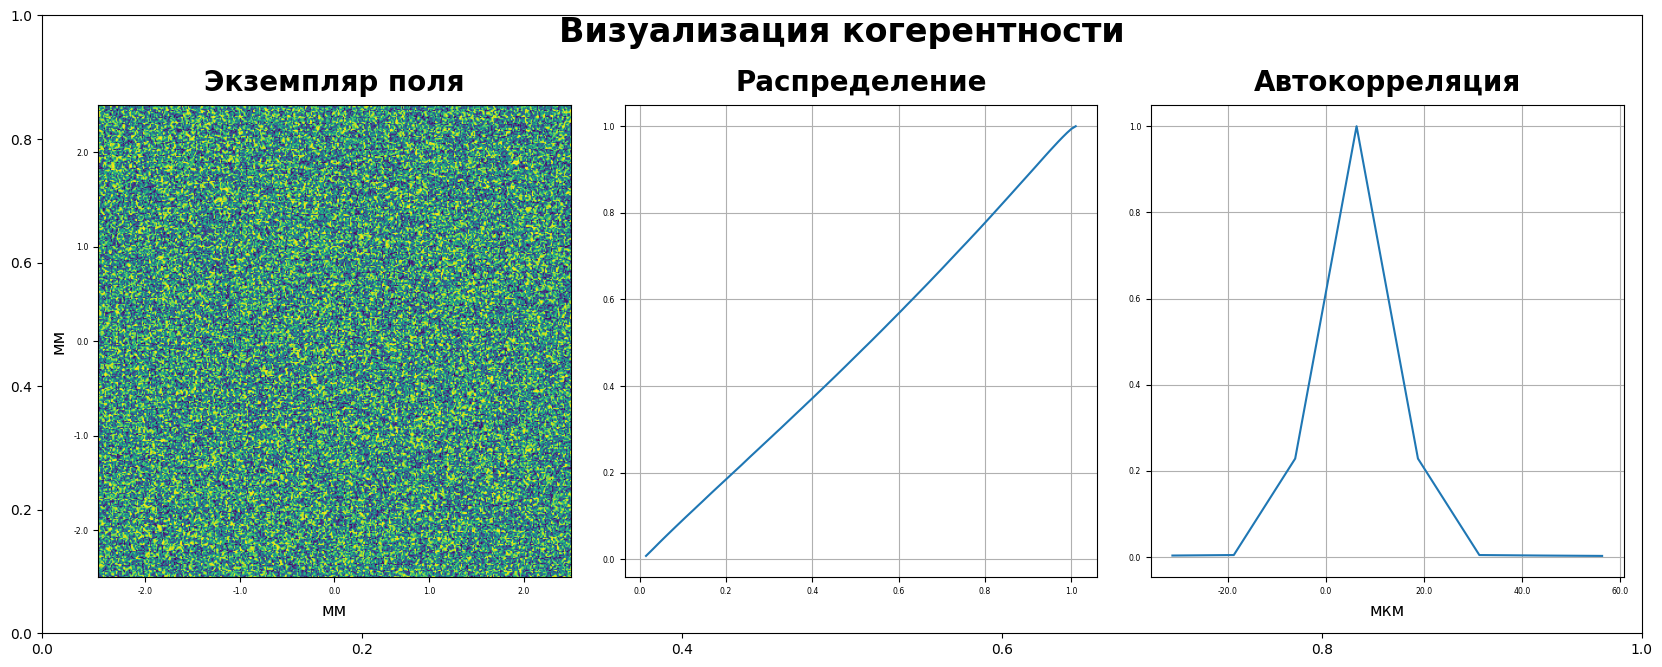

In [11]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Визуализация когерентности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_rad, unit_rad = engineering.separatedformatter(autocorr_radius, 'м')

axes = plot.axes.add(0,0)
axes.imshow(incoherent_sample, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Экземпляр поля')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(incoherent_distribution_values, incoherent_distribution.cpu())
plot.graph.title('Распределение')

p0 = int(autocorr.shape[1]*(1 - 4*autocorr_radius/length)/2)
p1 = p0 + int(8*autocorr.shape[1]*autocorr_radius/length)
axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(numpy.linspace(-length/2, +length/2, autocorr.shape[1])[p0:p1], autocorr[autocorr.shape[0]//2][p0:p1]/autocorr.max())
axes.xaxis.set_major_formatter(formatter_rad)
plot.graph.label.x(unit_rad)
plot.graph.title('Автокорреляция')

plot.show()

## Инициализация детекторов

In [12]:
detectors_amount = 24
detector_size = length / 60

spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((detector_size, detector_size), (0,0))
detectors = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter).to(device)

In [ ]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.pad.graph.horizontal(0.1)
plot.title('Характеристики детекторов')

x_linspace = torch.linspace(-4*detector_size,+4*detector_size,100)
y_linspace = detectors_filter(x_linspace, x_linspace)[50]
wl_linspace = torch.linspace(0, 1000.0E-9, 100)
s_linspace = spectral_filter(wl_linspace)
formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')
formatter_d, unit_d = scientific.separatedformatter(y_linspace.max(), '')
formatter_wl, unit_wl = engineering.separatedformatter(wl_linspace.max(), 'м')

axes = plot.axes.add(0,0)
axes.imshow(detectors.filter, aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)
plot.graph.title('Суммарная функция детекторов')

axes = plot.axes.add(1,0)
axes.grid(True)
axes.plot(x_linspace, y_linspace)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_d)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_d)
plot.graph.title('Пространственная функция детектора')

axes = plot.axes.add(2,0)
axes.grid(True)
axes.plot(wl_linspace, s_linspace)
axes.xaxis.set_major_formatter(formatter_wl)
plot.graph.label.x(unit_wl)
plot.graph.title('Спектральная функция детектора')

plot.show()

## Инициализация электронной части

In [ ]:
electronic = timm.create_model('resnet18', pretrained=True,  in_chans=1, num_classes=10).to(device)

## Комбинированная функция

In [ ]:
def combined_loss(cross_entropy_to_mse_proportion:float=1.0):
    def loss_function(outputs, targets):
        CELoss = torch.nn.functional.cross_entropy(outputs, targets)
        MSELoss = torch.nn.functional.mse_loss(torch.nn.functional.softmax(outputs, dim=1), torch.nn.functional.one_hot(targets, num_classes=10).float())
        loss = cross_entropy_to_mse_proportion*CELoss + (1.0-cross_entropy_to_mse_proportion)*MSELoss
        return loss
    return loss_function

## Выбор диапазона раcстояния распространения

In [ ]:
# Настройка диапазона
distance_left_multiplier = 0.05
distance_right_multiplier = 0.5

slices = 100
distance_samples = 4
distance_array = numpy.linspace(reference_distance*distance_left_multiplier, reference_distance*distance_right_multiplier, distance_samples)

In [ ]:
different_distance_propagations = []
# Вычисления
initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
p0 = N//2 - int(N*size/(length*2))
p1 = p0 + int(N*size/length)
initial[0,0,p0:p1,p0:p1] = 1.0

chunker = CudaMemoryChunker().to(device)
with torch.no_grad():
    for max_distance in tqdm(distance_array):
        result = torch.zeros((slices, N), dtype=torch.float32)
        for i, distance in enumerate(numpy.linspace(0, max_distance, slices)):
            propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance).to(device)
            chunker.attach_forward(propagation.forward)
            incoherent.attach_forward(chunker.forward)
            result[i] = incoherent.forward(initial)[0,0,N//2].abs().cpu()
        different_distance_propagations.append((max_distance, result))

In [ ]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Распостранение от единичной неоднородности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')

axes = plot.axes.add((0,0),(1,1))
axes.imshow(initial[0][0].abs().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)

plot.description.column.top('Исходное поле',0,1)

for col, (distance, data) in enumerate(different_distance_propagations, 2):
    formatter_z, unit_z = engineering.separatedformatter(distance, 'м')
    plot.description.column.top(f"Расстояние: {engineering(distance,'м', 2)}", col)

    axes = plot.axes.add(col, 0)
    axes.imshow(torch.log10(data+0.0001), aspect='auto', extent=[-length/2,+length/2,distance,0])
    axes.xaxis.set_major_formatter(formatter_xy)
    axes.yaxis.set_major_formatter(formatter_z)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_z)

    axes = plot.axes.add(col,1)
    axes.grid(True)
    axes.plot(numpy.linspace(-length/2,+length/2,N), data[-1]/data[-1].max())
    axes.xaxis.set_major_formatter(formatter_xy)
    plot.graph.label.x(unit_xy)

plot.show()

## Вариации изменяемых параметров

In [ ]:
# Установить вручную по картинкам выше (чем больше покрытие и меньше шумов, тем лучше)
distance_limits = (50.0E-3, 150.0E-3)

In [ ]:
masks_amount_limits = (3, 10)
batch_size_limits = (20, 60)
learning_rate_limits = (0.00001, 0.1)
loss_functions_proportion_limits = (0.0, 1.0)
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

## Вывод окончательных параметров

In [ ]:
print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(size, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

## Функция цели для optuna и оптимизация

In [ ]:
def objective(trial:optuna.trial):
    masks_amount = trial.suggest_int('masks amount', *masks_amount_limits)
    batch_size = trial.suggest_int('batch size', *batch_size_limits)
    distance = trial.suggest_float('distance', *distance_limits)
    learning_rate = trial.suggest_float('learning rate', *learning_rate_limits, log=True)
    loss_functions_proportion = trial.suggest_float('cross entorpy proportion', *loss_functions_proportion_limits)
    optimizer_type = trial.suggest_categorical('optimizer type', optimizer_types_list.keys())

    print('Эксперимент:')
    print(f"\tКоличетсво масок:  {masks_amount}")
    print(f"\tРазмер батча:      {batch_size}")
    print(f"\tДистанция:         {engineering(distance, 'м')}")
    print(f"\tСкорость обучения: {learning_rate}")
    print(f"\tПропорция CELoss:  {loss_functions_proportion}")
    print(f"\tТип оптимизатора:  {optimizer_type}")

    # Инициализация оптической части и гибридной модели
    propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
    phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
    amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
    elements = [phase_modulators[0], amplitude_modulators[0]]
    for phase_modulator, amplitude_modulator in zip(phase_modulators[1:], amplitude_modulators[1:]):
        elements.append(propagation)
        elements.append(phase_modulator)
        elements.append(amplitude_modulator)
    elements.append(propagation)
    chunker = CudaMemoryChunker()
    optical = CompositeModel(*elements)
    optical.wrap(chunker)
    optical.wrap(incoherent)
    optical.to(device)
    model = HybridModel(optical, detectors, electronic)

    # Подготовка данных, функции ошибки и оптимизатора
    dataset = Dataset('CIFAR10', batch_size, N, N, torch.complex64)
    dataset.train
    dataset.test
    loss_function = combined_loss(loss_functions_proportion)
    optimizer = optimizer_types_list[optimizer_type](model.parameters(), lr=learning_rate)

    # Обучение модели
    for i in range(optuna_epochs):
        train(model, dataset, optimizer, loss_function)
    confusion_matrix = confusion(model, dataset)
    return 100*numpy.sum(numpy.diagonal(confusion_matrix, 0))/numpy.sum(confusion_matrix)
study = optuna.create_study(direction='maximize')

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
study.optimize(objective, n_trials=5)

In [ ]:
print("Лучшие гиперпараметры:", study.best_trial.params)